# Delay Prediction in Dutch Train Services
## Model 1: Logistic Regression (First draft)

### Objective

The goal of this notebook is to build a **Logistic Regression** classifier to predict whether a train service will experience a **significant delay** (defined as Maximum Delay > 5 minutes).

The target variable is binary:
- 1 → the service has a maximum delay **strictly greater than 5 minutes**
- 0 → the service is on time or has a minor delay (≤ 5 minutes)

**Why binary classification instead of regression?**  
As shown in the EDA, the Service:Maximum delay distribution is heavily concentrated around 0. Predicting the exact delay value (regression) would be extremely noisy and uninformative. Framing this as a binary classification problem creates a realistic, interpretable, and operationally useful prediction task.

**Why Logistic Regression as a first model?**  
Logistic Regression is a strong, interpretable baseline. Its coefficients directly reveal which features push a service toward delay, making it ideal for understanding the data before moving to more complex models.

**Why did we chose a 5-minute threshold?**
The 5-minute threshold is standard in railway operations, delays below this are generally considered within acceptable tolerance for passengers.


### 1. Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    f1_score,
    precision_recall_curve,
    average_precision_score
)
from sklearn.pipeline import Pipeline

sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams.update({
    'figure.dpi': 130,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
})
PALETTE = sns.color_palette('muted')

### 2. Loading the Cleaned Dataset

We load df_clean.csv, which was saved at the end of the EDA notebook.  
Each row is a stop within a service. Since Service:Maximum delay is only meaningful on the **first row of each service** (subsequent rows within the same Service:RDT-ID hold 0), we immediately aggregate to the **service level**.

In [2]:
df_clean = pd.read_csv('df_clean.csv', low_memory=False)
print(f'df_clean loaded: {df_clean.shape[0]:,} rows, {df_clean.shape[1]} columns')
df_clean.head(3)

df_clean loaded: 21,838,516 rows, 17 columns


,Service:RDT-ID,Service:Date,Service:Type,Service:Company,Service:Train number,Service:Completely cancelled,Service:Partly cancelled,Service:Maximum delay,Stop:RDT-ID,Stop:Station name,Stop:Arrival time,Stop:Arrival delay,Stop:Arrival cancelled,Stop:Departure time,Stop:Departure delay,Stop:Departure cancelled,Stop:Platform change
0,12690865,2024-01-01,Intercity,NS,1410,False,False,2,114307592,Rotterdam Centraal,NaN,NaN,True,2024-01-01 02:00:00+01:00,0.0,False,False
1,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307593,Delft,2024-01-01 02:13:00+01:00,0.0,False,2024-01-01 02:13:00+01:00,0.0,False,False
2,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307594,Den Haag HS,2024-01-01 02:21:00+01:00,0.0,False,2024-01-01 02:22:00+01:00,0.0,False,False


In [4]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21838516 entries, 0 to 21838515
Data columns (total 17 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   Service:RDT-ID                int64         
 1   Service:Date                  datetime64[ns]
 2   Service:Type                  object        
 3   Service:Company               object        
 4   Service:Train number          int64         
 5   Service:Completely cancelled  bool          
 6   Service:Partly cancelled      bool          
 7   Service:Maximum delay         int64         
 8   Stop:RDT-ID                   int64         
 9   Stop:Station name             object        
 10  Stop:Arrival time             object        
 11  Stop:Arrival delay            float64       
 12  Stop:Arrival cancelled        bool          
 13  Stop:Departure time           object        
 14  Stop:Departure delay          float64       
 15  Stop:Departure cancelled      

#### Create Time-Based Features
This allows: rush hour analysis, weekend vs weekday delay and seasonal patterns

In [ ]:
cols= ["Stop:Departure time", "Stop:Arrival time", "Service:Date"]
for c in cols:
    if not pd.api.types.is_datetime64_any_dtype(df_clean[c]):
        df_clean[c] = pd.to_datetime(df_clean[c], errors="coerce")

df_clean["hour_departure"]= df_clean["Stop:Departure time"].dt.hour.astype("Int64")
df_clean["hour_arrival"] = df_clean["Stop:Arrival time"].dt.hour.astype("Int64")
df_clean["day_of_week"] = df_clean["Service:Date"].dt.dayofweek.astype("Int64")
df_clean["month"] = df_clean["Service:Date"].dt.month.astype("Int64")

print("dtypes:")
print(df_clean[cols].dtypes)

df_clean[["hour_departure","hour_arrival","day_of_week","month"]].head()

dtypes:
Stop:Departure time    datetime64[ns, UTC+01:00]
Stop:Arrival time      datetime64[ns, UTC+01:00]
Service:Date                      datetime64[ns]
dtype: object


,hour_departure,hour_arrival,day_of_week,month
0,2,<NA>,0,1
1,2,2,0,1
2,2,2,0,1
3,2,2,0,1
4,3,3,0,1


In [6]:
df_clean.head()

,Service:RDT-ID,Service:Date,Service:Type,Service:Company,Service:Train number,Service:Completely cancelled,Service:Partly cancelled,Service:Maximum delay,Stop:RDT-ID,Stop:Station name,...,Stop:Arrival delay,Stop:Arrival cancelled,Stop:Departure time,Stop:Departure delay,Stop:Departure cancelled,Stop:Platform change,hour_departure,hour_arrival,day_of_week,month
0,12690865,2024-01-01,Intercity,NS,1410,False,False,2,114307592,Rotterdam Centraal,...,NaN,True,2024-01-01 02:00:00+01:00,0.0,False,False,2,<NA>,0,1
1,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307593,Delft,...,0.0,False,2024-01-01 02:13:00+01:00,0.0,False,False,2,2,0,1
2,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307594,Den Haag HS,...,0.0,False,2024-01-01 02:22:00+01:00,0.0,False,False,2,2,0,1
3,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307595,Leiden Centraal,...,0.0,False,2024-01-01 02:40:00+01:00,0.0,False,True,2,2,0,1
4,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307596,Schiphol Airport,...,0.0,False,2024-01-01 03:03:00+01:00,0.0,False,False,3,3,0,1


### 3. Building the Service-Level Dataset

We aggregate the stop-level data to the service level.  
For each Service:RDT-ID, we extract:
- The first row (which holds the correct Service:Maximum delay value)
- Aggregated stop-level features (proportion of stops with platform change, mean arrival/departure delays across stops)

In [7]:
df_clean['Service:Date'] = pd.to_datetime(df_clean['Service:Date'], errors='coerce')
df_clean['Stop:Arrival time'] = pd.to_datetime(df_clean['Stop:Arrival time'], utc=True, errors='coerce')
df_clean['Stop:Departure time'] = pd.to_datetime(df_clean['Stop:Departure time'], utc=True, errors='coerce')

df_clean['dep_hour'] = df_clean['Stop:Departure time'].dt.tz_convert('Europe/Amsterdam').dt.hour

for col in ['Stop:Platform change', 'Service:Completely cancelled', 'Service:Partly cancelled',
            'Stop:Arrival cancelled', 'Stop:Departure cancelled']:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(str).str.strip().str.lower().map(
            {'true': 1, 'false': 0, '1': 1, '0': 0}
        ).fillna(0).astype(int)

df_clean['Stop:Arrival delay'] = pd.to_numeric(df_clean['Stop:Arrival delay'], errors='coerce')
df_clean['Stop:Departure delay'] = pd.to_numeric(df_clean['Stop:Departure delay'], errors='coerce')

In [ ]:
# First row of each service carries the correct Service:Maximum delay
df_first = (
    df_clean
    .groupby('Service:RDT-ID', as_index=False)
    .first()
    [['Service:RDT-ID', 'Service:Date', 'Service:Type', 'Service:Company',
      'Service:Maximum delay', 'Service:Completely cancelled',
      'Service:Partly cancelled', 'dep_hour']]
)

# Aggregated stop-level features across ALL stops of the service
df_agg = (
    df_clean
    .groupby('Service:RDT-ID')
    .agg(
        n_stops= ('Stop:RDT-ID', 'count'),
        mean_arr_delay= ('Stop:Arrival delay', 'mean'),
        mean_dep_delay= ('Stop:Departure delay', 'mean'),
        max_arr_delay= ('Stop:Arrival delay', 'max'),
        max_dep_delay= ('Stop:Departure delay', 'max'),
        platform_change_rate= ('Stop:Platform change', 'mean'),
        any_arr_cancelled= ('Stop:Arrival cancelled', 'max'),
        any_dep_cancelled= ('Stop:Departure cancelled', 'max'),
    )
    .reset_index()
)

# Merge
df_service = df_first.merge(df_agg, on='Service:RDT-ID', how='left')

# Temporal features
df_service['month']= df_service['Service:Date'].dt.month
df_service['day_of_week']= df_service['Service:Date'].dt.dayofweek   # 0=Monday
df_service['week']= df_service['Service:Date'].dt.isocalendar().week.astype(int)
df_service['is_weekend']= (df_service['day_of_week'] >= 5).astype(int)

# Peak hour flag (7-9h and 17-19h) (based on the viz in the EDA notebook)
df_service['is_peak_hour']= df_service['dep_hour'].apply(
    lambda h: 1 if (7 <= h <= 9 or 17 <= h <= 19) else 0
)

print(f'Service-level dataset: {df_service.shape[0]:,} services, {df_service.shape[1]} columns')
df_service.head()

Service-level dataset: 2,395,636 services, 21 columns


,Service:RDT-ID,Service:Date,Service:Type,Service:Company,Service:Maximum delay,Service:Completely cancelled,Service:Partly cancelled,dep_hour,n_stops,mean_arr_delay,...,max_arr_delay,max_dep_delay,platform_change_rate,any_arr_cancelled,any_dep_cancelled,month,day_of_week,week,is_weekend,is_peak_hour
0,12690865,2024-01-01,Intercity,NS,2,0,0,2.0,9,0.375000,...,2.0,2.0,0.111111,1,1,1,0,1,0,0
1,12690866,2024-01-01,Nightjet,NS Int,6,0,0,2.0,8,0.714286,...,4.0,6.0,0.000000,1,1,1,0,1,0,0
2,12690867,2024-01-01,Intercity,NS,10,0,0,2.0,9,4.500000,...,10.0,10.0,0.222222,1,1,1,0,1,0,0
3,12690868,2024-01-01,Intercity,NS,5,0,0,2.0,4,2.666667,...,5.0,2.0,0.250000,1,1,1,0,1,0,0
4,12690869,2024-01-01,Stoptrein,Eurobahn,0,1,1,2.0,4,0.000000,...,0.0,0.0,0.000000,1,1,1,0,1,0,0


### 4. Defining the Target Variable

We create significant_delay as a binary indicator:

$$\text{significant\_delay} = \mathbb{1}[\text{Service:Maximum delay} > 5]$$

In [ ]:
df_service['significant_delay'] = (df_service['Service:Maximum delay'] > 5).astype(int)

counts = df_service['significant_delay'].value_counts()
pct = df_service['significant_delay'].value_counts(normalize=True) * 100

print('Target variable distribution:')
print(f'  0 – On time / minor delay: {counts[0]:>10,}  ({pct[0]:.1f}%)')
print(f'  1 – Significant delay: {counts[1]:>10,}  ({pct[1]:.1f}%)')

Target variable distribution:
  0 – On time / minor delay :  2,193,409  (91.6%)
  1 – Significant delay     :    202,227  (8.4%)

Class imbalance ratio: 10.8:1


The dataset is imbalanced

### 5. Feature Engineering and Selection

We select features that:
1. Were identified as relevant during EDA
2. Do not directly encode the target (we exclude Service:Maximum delay itself)

**Features used:**

| Feature | Type | Description |
|---|---|---|
| Service:Type | Categorical | Train type |
| Service:Company | Categorical | Operating company |
| month | Numerical | Month of service (1–12) |
| day_of_week | Numerical | Day of week (0=Mon, 6=Sun) |
| is_weekend | Binary | 1 if Saturday or Sunday |
| dep_hour | Numerical | Hour of first departure |
| is_peak_hour | Binary | 1 if departure in rush hour |
| n_stops | Numerical | Number of stops in the service |
| platform_change_rate | Numerical | Proportion of stops with platform change |
| Service:Completely cancelled | Binary | Whether service is fully cancelled |
| Service:Partly cancelled | Binary | Whether service is partly cancelled |
| any_arr_cancelled | Binary | Any stop with cancelled arrival |
| any_dep_cancelled | Binary | Any stop with cancelled departure |

In [ ]:
CATEGORICAL_FEATURES = ['Service:Type', 'Service:Company']
NUMERICAL_FEATURES   = [
    'month', 'day_of_week', 'dep_hour', 'is_weekend', 'is_peak_hour',
    'n_stops', 'platform_change_rate',
    'Service:Completely cancelled', 'Service:Partly cancelled',
    'any_arr_cancelled', 'any_dep_cancelled'
]
TARGET = 'significant_delay'

# Encode categorical features 
df_model = df_service.copy()

for col in CATEGORICAL_FEATURES:
    le = LabelEncoder()
    df_model[col + '_enc'] = le.fit_transform(df_model[col].astype(str))

ENCODED_CAT = [c + '_enc' for c in CATEGORICAL_FEATURES]
ALL_FEATURES = NUMERICAL_FEATURES + ENCODED_CAT

# Drop rows with NaN in features or target
df_model = df_model[ALL_FEATURES + [TARGET]].dropna()

print(f'Model dataset: {df_model.shape[0]:,} services × {len(ALL_FEATURES)} features')
print(f'Features used: {ALL_FEATURES}')

Model dataset: 1,001,558 services × 13 features
Features used: ['month', 'day_of_week', 'dep_hour', 'is_weekend', 'is_peak_hour', 'n_stops', 'platform_change_rate', 'Service:Completely cancelled', 'Service:Partly cancelled', 'any_arr_cancelled', 'any_dep_cancelled', 'Service:Type_enc', 'Service:Company_enc']


### 6. Train / Test Split

We use a **stratified 80/20 split**.  

In [13]:
X = df_model[ALL_FEATURES]
y = df_model[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print(f'Training set : {X_train.shape[0]:,} services')
print(f'Test set     : {X_test.shape[0]:,} services')
print(f'\nClass distribution in training set:')
print(y_train.value_counts(normalize=True).round(3))
print(f'\nClass distribution in test set:')
print(y_test.value_counts(normalize=True).round(3))

Training set : 801,246 services
Test set     : 200,312 services

Class distribution in training set:
significant_delay
0    0.908
1    0.092
Name: proportion, dtype: float64

Class distribution in test set:
significant_delay
0    0.908
1    0.092
Name: proportion, dtype: float64


### 7. Model Training

We use a **sklearn Pipeline** that chains:
1. StandardScaler → normalizes all numerical features to zero mean and unit variance
2. LogisticRegression with:
   - class_weight='balanced' → automatically adjusts weights inversely proportional to class frequencies, correcting the imbalance
   - max_iter=1000 → ensures convergence on large datasets
   - solver='lbfgs'`→ efficient for medium-to-large datasets

**Why class_weight='balanced'?**  
Without it, the model would learn to predict "class 0" for almost everything and achieve ~80%+ accuracy while being completely useless. Balancing forces the model to genuinely learn to distinguish delayed services.

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',   LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        solver='lbfgs',
        random_state=42,
        n_jobs=-1
    ))
])

pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best C value : 0.1
Best CV F1   : 0.3131


### 8. Evaluation

We evaluate using metrics appropriate for imbalanced classification:

- **F1-score** (weighted and per class): harmonic mean of precision and recall
- **AUC-ROC**: ability to distinguish between classes across all thresholds
- **Average Precision (PR-AUC)**: area under the Precision-Recall curve, more informative than ROC for imbalanced data
- **Confusion matrix**: shows exact counts of TP, TN, FP, FN

In [ ]:
y_pred      = pipeline.predict(X_test)
y_pred_proba= pipeline.predict_proba(X_test)[:, 1]

f1_delayed  = f1_score(y_test, y_pred, pos_label=1)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
auc_roc     = roc_auc_score(y_test, y_pred_proba)
avg_prec    = average_precision_score(y_test, y_pred_proba)

print('=' * 50)
print('  LOGISTIC REGRESSION – TEST SET RESULTS')
print('=' * 50)
print(f'  F1-score (significant delay, class 1) : {f1_delayed:.4f}')
print(f'  F1-score (weighted average) : {f1_weighted:.4f}')
print(f'  AUC-ROC  {auc_roc:.4f}')
print(f'  Average Precision (PR-AUC) : {avg_prec:.4f}')
print('=' * 50)
print()
print('Detailed Classification Report:')
print(classification_report(y_test, y_pred,
                             target_names=['On time (0)', 'Significant delay (1)']))

  LOGISTIC REGRESSION – TEST SET RESULTS
  F1-score (significant delay, class 1) : 0.3117
  F1-score (weighted average)            : 0.7856
  AUC-ROC                                : 0.7680
  Average Precision (PR-AUC)             : 0.2644

Detailed Classification Report:
                       precision    recall  f1-score   support

          On time (0)       0.96      0.74      0.83    181835
Significant delay (1)       0.20      0.66      0.31     18477

             accuracy                           0.73    200312
            macro avg       0.58      0.70      0.57    200312
         weighted avg       0.89      0.73      0.79    200312



#### 8.1 Confusion Matrix

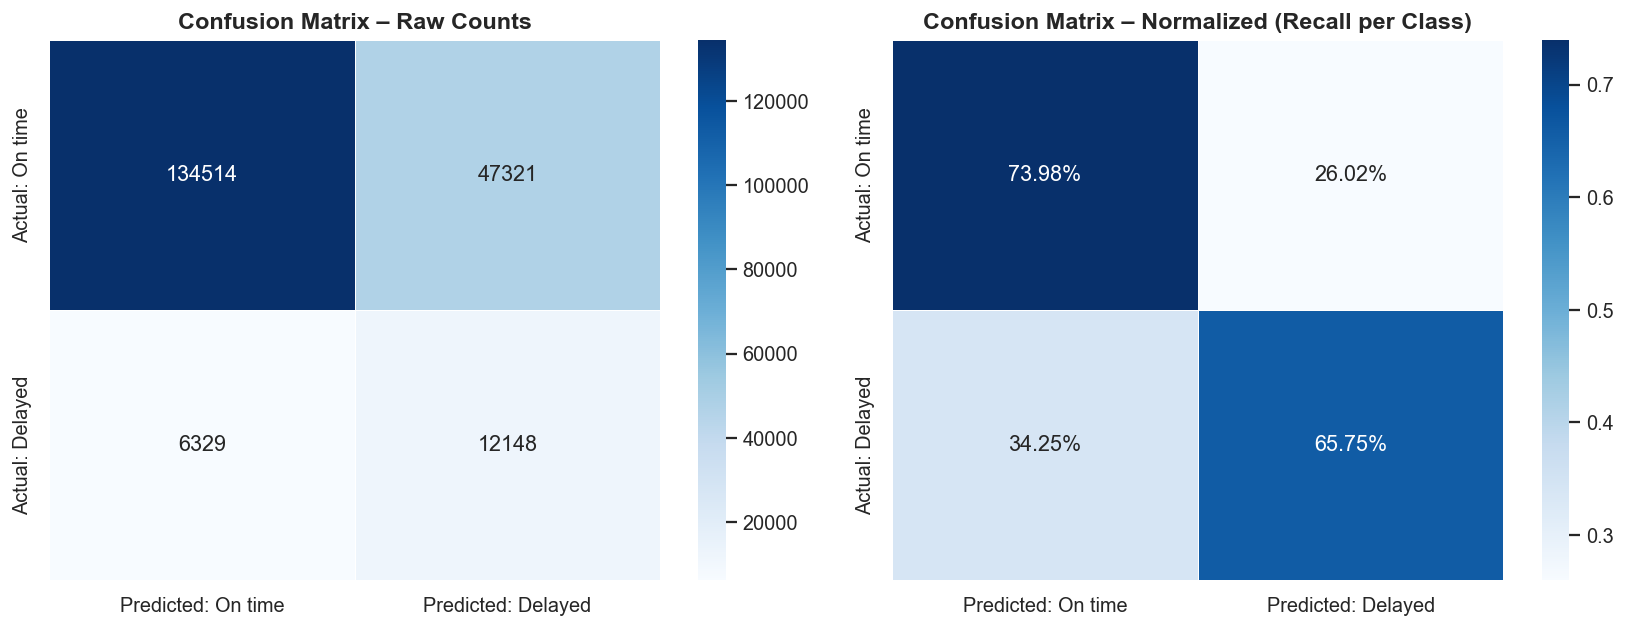

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Predicted: On time', 'Predicted: Delayed'],
            yticklabels=['Actual: On time', 'Actual: Delayed'],
            linewidths=0.5, linecolor='white')
axes[0].set_title('Confusion Matrix – Raw Counts', fontweight='bold')

sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=['Predicted: On time', 'Predicted: Delayed'],
            yticklabels=['Actual: On time', 'Actual: Delayed'],
            linewidths=0.5, linecolor='white')
axes[1].set_title('Confusion Matrix – Normalized (Recall per Class)', fontweight='bold')

plt.tight_layout()
plt.show()

#### 8.2 ROC Curve and Precision-Recall Curve

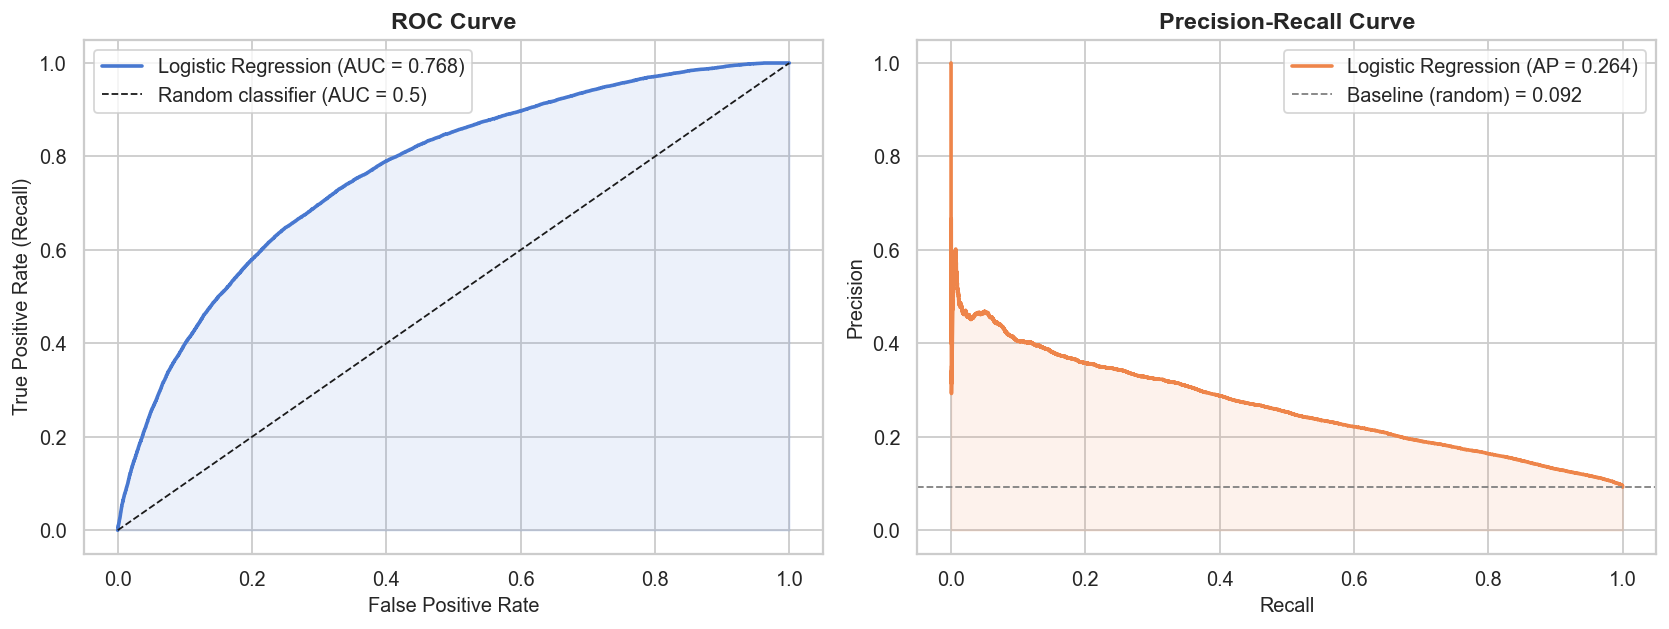

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# ROC Curve 
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0].plot(fpr, tpr, lw=2, color=PALETTE[0],
             label=f'Logistic Regression (AUC = {auc_roc:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', lw=1, label='Random classifier (AUC = 0.5)')
axes[0].fill_between(fpr, tpr, alpha=0.1, color=PALETTE[0])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate (Recall)')
axes[0].set_title('ROC Curve', fontweight='bold')
axes[0].legend()

#  Precision-Recall Curve 
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
baseline = y_test.mean()
axes[1].plot(recall, precision, lw=2, color=PALETTE[1],
             label=f'Logistic Regression (AP = {avg_prec:.3f})')
axes[1].axhline(baseline, color='gray', linestyle='--', lw=1,
                label=f'Baseline (random) = {baseline:.3f}')
axes[1].fill_between(recall, precision, alpha=0.1, color=PALETTE[1])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

#### Model Performance Interpretation

The initial results of the Logistic Regression model provide a baseline for predicting significant train delays (> 5min). 
While the AUC-ROC of 0.768 suggests a fair overall ability to distinguish between classes, a deeper look at the metrics reveals the challenges posed by the heavy class imbalance (approximately 9% delays vs. 91% on-time).

1. Detection Capability (Recall): The model successfully identifies 66% of actual delays (Recall for Class 1). This indicates that the model captures about two-thirds of the delay events in the test set.
2. The Precision-Recall Trade-off: The Average Precision (AP) of 0.264, while significantly higher than the random baseline of 0.092, highlights the model's struggle with False Positives. The precision for delays is currently 0.20, meaning that when the model predicts a delay, it is correct only 20% of the time.
3. F1-Score Analysis: The low F1-score of 0.31 for Class 1 confirms that the current model is not yet optimized for practical use, as it generates a high number of "false alarms" (47321 False Positives)

#### Perspectives for Model Optimization

To move beyond this first draft and specifically target an increase in the F1-score, the following strategies will be implemented:
1. Feature Refinement (Guided by Feature Importance): As explored in the next section, identifying the most predictive features is crucial. We will perform feature selection to remove noise and focus on variables with the highest impact on delays.
2. Addressing Class Imbalance: Since the dataset is highly imbalanced, we will experiment with SMOTE (Synthetic Minority Over-sampling Technique) or adjust class weights within the model to give more importance to the "Significant delay" class.
3. Threshold Optimization: The default classification threshold of 0.5 may not be ideal. We will perform a threshold moving analysis to find the optimal balance between precision and recall that maximizes the F1-score.

### 9. Feature Importance via Model Coefficients

One of the key advantages of Logistic Regression is **interpretability**.  
The model coefficients (after scaling) indicate the direction and magnitude of each feature's influence on the predicted probability of a significant delay.

- **Positive coefficient** → increases probability of significant delay
- **Negative coefficient** → decreases probability of significant delay

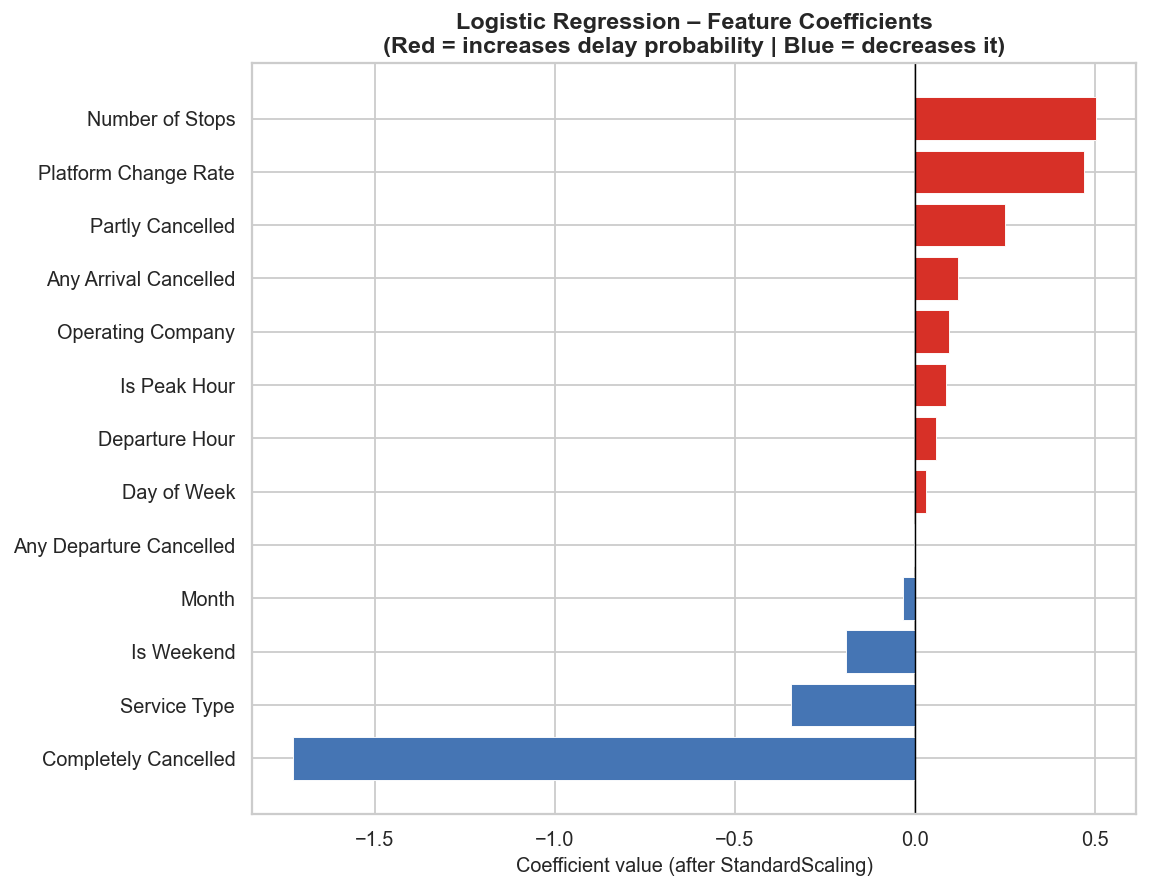

          Feature_clean  Coefficient
        Number of Stops     0.502201
   Platform Change Rate     0.470158
       Partly Cancelled     0.250502
  Any Arrival Cancelled     0.118181
      Operating Company     0.093413
           Is Peak Hour     0.085253
         Departure Hour     0.056814
            Day of Week     0.029745
Any Departure Cancelled    -0.002209
                  Month    -0.032257
             Is Weekend    -0.192228
           Service Type    -0.344746
   Completely Cancelled    -1.727683


In [ ]:
coef = pipeline.named_steps['clf'].coef_[0]
feature_names = ALL_FEATURES

coef_df = pd.DataFrame({
    'Feature'    : feature_names,
    'Coefficient': coef
}).sort_values('Coefficient', ascending=True)

name_map = {
    'Service:Type_enc'              : 'Service Type',
    'Service:Company_enc'           : 'Operating Company',
    'month'                         : 'Month',
    'day_of_week'                   : 'Day of Week',
    'dep_hour'                      : 'Departure Hour',
    'is_weekend'                    : 'Is Weekend',
    'is_peak_hour'                  : 'Is Peak Hour',
    'n_stops'                       : 'Number of Stops',
    'platform_change_rate'          : 'Platform Change Rate',
    'Service:Completely cancelled'  : 'Completely Cancelled',
    'Service:Partly cancelled'      : 'Partly Cancelled',
    'any_arr_cancelled'             : 'Any Arrival Cancelled',
    'any_dep_cancelled'             : 'Any Departure Cancelled',
}
coef_df['Feature_clean'] = coef_df['Feature'].map(name_map).fillna(coef_df['Feature'])

fig, ax = plt.subplots(figsize=(9, 7))
colors_bar = ['#d73027' if c > 0 else '#4575b4' for c in coef_df['Coefficient']]

ax.barh(coef_df['Feature_clean'], coef_df['Coefficient'],
        color=colors_bar, edgecolor='white', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('Coefficient value (after StandardScaling)')
ax.set_title('Logistic Regression – Feature Coefficients\n'
             '(Red = increases delay probability | Blue = decreases it)',
             fontweight='bold')
plt.tight_layout()
plt.show()

print(coef_df[['Feature_clean', 'Coefficient']].sort_values('Coefficient', ascending=False).to_string(index=False))